## Instalar Dependências do Python

In [16]:
!pip install --upgrade pip
!pip install onnx onnxruntime seaborn tf2onnx
!pip install timer

### Importar as dependências para treinamento do modelo

In [2]:
import numpy as np
import pandas as pd
import datetime
import os
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
import tf2onnx
import onnx
import time
import pickle
from pathlib import Path

2024-06-11 03:32:05.292277: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-11 03:32:07.663684: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Carregar os dados Brutos/Tratos 

Os dados CSV usados para treinar o modelo contêm os seguintes campos

* **distancefromhome** - Distancia onde a transação original ocorreu.
* **distancefromlast_transaction** - A distância desde a última transação ocorridaA distância desde a última transação ocorrida.
* **ratiotomedianpurchaseprice** - A proporção do preço de compra em comparação com o preço de compra médio.
* **repeat_retailer** - Se for de um varejista que já tenha comprado antes.
* **used_chip** - Se o chip do cartão de crédito foi utilizado.
* **usedpinnumber** - Se o número PIN foi usado.
* **online_order** - Se foi uma compra online.
* **fraud** - É uma Fraude.

In [3]:
Data = pd.read_csv('data/card_transdata.csv')
Data.head()

distance_from_home  distance_from_last_transaction  \
0           57.877857                        0.311140   
1           10.829943                        0.175592   
2            5.091079                        0.805153   
3            2.247564                        5.600044   
4           44.190936                        0.566486   

   ratio_to_median_purchase_price  repeat_retailer  used_chip  \
0                        1.945940              1.0        1.0   
1                        1.294219              1.0        0.0   
2                        0.427715              1.0        0.0   
3                        0.362663              1.0        1.0   
4                        2.222767              1.0        1.0   

   used_pin_number  online_order  fraud  
0              0.0           0.0    0.0  
1              0.0           0.0    0.0  
2              0.0           1.0    0.0  
3              0.0           1.0    0.0  
4              0.0           1.0    0.0

In [4]:
# Defina os dados de entrada (X) e saída (Y). 
# Os únicos dados de saída são se são fraudulentos. Todos os outros campos são entradas para o modelo.

X = Data.drop(columns = ['repeat_retailer','distance_from_home', 'fraud'])
y = Data['fraud']

# Dividindo os dados em conjuntos de treinamento e teste para ter algo para testar o modelo treinado.
# X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, stratify = y)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, shuffle = False)

X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size = 0.2, stratify = y_train)

# Dimensione os dados para remover a média e ter variação unitária. Os dados estarão entre -1 e 1, o que torna muito mais fácil para o modelo aprender do que valores aleatórios (e potencialmente grandes).
# É importante ajustar o escalonador apenas aos dados de treinamento, caso contrário você estará vazando informações sobre a distribuição global de variáveis (que é influenciada pelo conjunto de teste) no conjunto de treinamento.

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train.values)

Path("artifact").mkdir(parents=True, exist_ok=True)
with open("artifact/test_data.pkl", "wb") as handle:
    pickle.dump((X_test, y_test), handle)
with open("artifact/scaler.pkl", "wb") as handle:
    pickle.dump(scaler, handle)

# Como o conjunto de dados é desequilibrado (tem muito mais transações não fraudulentas do que fraudulentas), defina um peso de classe para ponderar mais as poucas transações fraudulentas do que as muitas transações não fraudulentas.

class_weights = class_weight.compute_class_weight('balanced',classes = np.unique(y_train),y = y_train)
class_weights = {i : class_weights[i] for i in range(len(class_weights))}

## Construindo o modelo

O modelo é uma rede neural profunda simples e totalmente conectada, contendo três camadas ocultas e uma camada de saída.Construa o modelo

In [5]:
model = Sequential()
model.add(Dense(32, activation = 'relu', input_dim = len(X.columns)))
model.add(Dropout(0.2))
model.add(Dense(32))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(32))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                192       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 batch_normalization (Batch  (None, 32)                128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 32)                0         
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                        

## Treinando o Modelo

Treinar um modelo costuma ser a parte mais demorada do processo de aprendizado de máquina.  Modelos grandes podem usar várias GPUs por dias.  Espere que o treinamento na CPU para este modelo muito simples leve um minuto ou mais.

In [6]:
# Treinando o o modelo e obtenha desempenho e performance
start_time = time.time()
epochs = 2
history = model.fit(X_train, y_train, epochs=epochs, \
                    validation_data=(scaler.transform(X_val.values),y_val), \
                    verbose = True, class_weight = class_weights)
end_time = time.time()
training_time = end_time - start_time
print("Modelo Treinado !!")
print (training_time)

Epoch 1/2
20000/20000 [==============================] - 56s 3ms/step - loss: 0.2607 - accuracy: 0.9287 - val_loss: 0.2487 - val_accuracy: 0.9342
Epoch 2/2
20000/20000 [==============================] - 54s 3ms/step - loss: 0.2365 - accuracy: 0.9476 - val_loss: 0.2305 - val_accuracy: 0.9437
Modelo Treinado !!
110.53618311882019


## Salvando o Modelo

In [7]:
# Salvando o modelo como ONNX 
model_proto, _ = tf2onnx.convert.from_keras(model)
os.makedirs("models/fraude/1", exist_ok=True)
onnx.save(model_proto, "models/fraude/1/model.onnx")

Could not search for non-variable resources. Concrete function internal representation may have changed.
2024-06-11 03:34:04.165192: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-06-11 03:34:04.165481: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2024-06-11 03:34:04.261126: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-06-11 03:34:04.261618: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session


## Confirmar se o Modelo foi salvo com suscesso

A saída deve incluir o nome do modelo, tamanho e data.

In [8]:
! ls -alRh ./models/

./models/:
total 12K
drwxrwsr-x.  3 1000960000 1000960000 4.0K Jun 10 22:07 .
drwxrwsr-x. 12 1000960000 1000960000 4.0K Jun 11 03:33 ..
drwxrwsr-x.  3 1000960000 1000960000 4.0K Jun 10 22:07 fraude

./models/fraude:
total 12K
drwxrwsr-x. 3 1000960000 1000960000 4.0K Jun 10 22:07 .
drwxrwsr-x. 3 1000960000 1000960000 4.0K Jun 10 22:07 ..
drwxrwsr-x. 3 1000960000 1000960000 4.0K Jun 11 03:34 1

./models/fraude/1:
total 28K
drwxrwsr-x. 3 1000960000 1000960000 4.0K Jun 11 03:34 .
drwxrwsr-x. 3 1000960000 1000960000 4.0K Jun 10 22:07 ..
drwxr-sr-x. 2 1000960000 1000960000 4.0K Jun 11 03:26 .ipynb_checkpoints
-rw-r--r--. 1 1000960000 1000960000  13K Jun 11 03:34 model.onnx

./models/fraude/1/.ipynb_checkpoints:
total 8.0K
drwxr-sr-x. 2 1000960000 1000960000 4.0K Jun 11 03:26 .
drwxrwsr-x. 3 1000960000 1000960000 4.0K Jun 11 03:34 ..


## Testando o Modelo

In [9]:
from sklearn.metrics import confusion_matrix
import numpy as np
import pickle
import seaborn as sns
from matplotlib import pyplot as plt
import onnxruntime as rt

## Carregue os dados de teste e o escalonador

In [10]:
with open('artifact/scaler.pkl', 'rb') as handle:
    scaler = pickle.load(handle)
with open('artifact/test_data.pkl', 'rb') as handle:
    (X_test, y_test) = pickle.load(handle)

Criando um ONNX inference runtime e previsão com valores de entrada

In [11]:
sess = rt.InferenceSession("models/fraude/1/model.onnx", providers=rt.get_available_providers())
input_name = sess.get_inputs()[0].name
output_name = sess.get_outputs()[0].name
y_pred_temp = sess.run([output_name], {input_name: scaler.transform(X_test.values).astype(np.float32)}) 
y_pred_temp = np.asarray(np.squeeze(y_pred_temp[0]))
threshold = 0.995
y_pred = np.where(y_pred_temp > threshold, 1,0)

Mostrando Resultado e Matriz de Confusão:

Accuracy: 0.963585


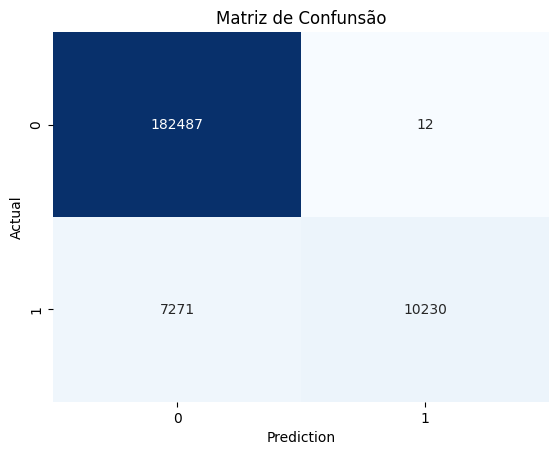

In [12]:
accuracy = np.sum(np.asarray(y_test) == y_pred) / len(y_pred)
print("Accuracy: " + str(accuracy))

c_matrix = confusion_matrix(np.asarray(y_test),y_pred)
ax = sns.heatmap(c_matrix, annot=True,fmt='d', cbar=False, cmap='Blues')
ax.set_xlabel("Prediction")
ax.set_ylabel("Actual")
ax.set_title('Matriz de Confunsão')
plt.show()

## Exemplo: A transação do Chico Bento seria uma fraude?

* distance_from_last_transaction
* ratio_to_median_price
* used_chip 
* used_pin_number
* online_order 

In [13]:
chico_transaction = [
    [0.3111400080477545,
    1.9459399775518593, 
    1.0, 
    0.0, 
    0.0]
    ]

prediction = sess.run([output_name], {input_name: scaler.transform(chico_transaction).astype(np.float32)})

print("A transação do Chico Bento é considerada fraude ? (verdadeiro = SIM, falso = NÃO)")
print(np.squeeze(prediction) > threshold)

print("Qual a probabilidade de a transação do Chico Bento ser uma fraude ? ")
print("{:.5f}".format(np.squeeze(prediction)) + "%")

A transação do Chico Bento é considerada fraude ? (verdadeiro = SIM, falso = NÃO)
False
Qual a probabilidade de a transação do Chico Bento ser uma fraude ? 
0.00089%
